# Model Outputs

After [runing a Pywr-DRB simulation](../Running_Simulations/run_all_simulations.md) the simulation data will be stored in `Pywr-DRB/output_data/drb_output_<inflow_type>.hdf5` where `inflow_type` corresponds to one of the naming conventions listed in [Data Summary](../../Supplemental/data_summary.md).

This file contains daily simulated values for every node in the model. 


In [1]:
import matplotlib.pyplot as plt
import h5py
import os

os.chdir('../../../')
from drb_make_figs import get_pywr_results, get_base_results

In [2]:
# Open the file and read the variable names (keys)
with h5py.File(f'./output_data/drb_output_obs_pub.hdf5', 'r') as f:
    stored_keys = list(f.keys())

print(f'There are {len(stored_keys)} variables stored in this file!')

There are 1535 variables stored in this file!


The majority of the variables stored in the `hdf5` file will not be of interest when assessing the system; we want to focus on the data at the 32 major nodes in model.


The function [`get_pywr_results()`](../../API_References/drb_make_figs.md) is designed to extract variables of interest from the `hdf5` file and returns a pandas DataFrame.


The `get_pywr_results()` function takes three inputs:

- `output_dir` (str): The relative path to the output data folder.
- `model` (str): The indicator name for the dataset of interest. See the [Data Summary](../Supplemental/data_summary.md) page for more info.
- `results_set` (str): Specify which types of model nodes to retrieve from the output file. Options for `results_set` are:
    - 'all': For reservoir releases and flow data at all nodes.
    - 'res_releases': Only reservoir release data.
    - 'major_flow': Streamflow data at only the major nodes.
    - 'res_storage': Only reservoir storage data.
    - 'inflow': Catchment inflow data at each major node.



Here is an example usage of `get_pywr_results` to retrieve the simulated streamflow at each of the major nodes in the model:

In [3]:
# Load Pywr-DRB simulation flow results at major nodes
simulated_flows = get_pywr_results('./output_data/', 
                                   model = 'obs_pub', 
                                   results_set = 'major_flow')

# Report the size of the retrieved data
print(f'The resulting dataframe has {simulated_flows.shape[0]} days of data at {simulated_flows.shape[1]} different nodes.')

# Display the data
simulated_flows.tail(2)


The resulting dataframe has 4018 days of data at 14 different nodes.


,01417000,01425000,01433500,01436000,01447800,01449800,01463620,01470960,delLordville,delMontague,delTrenton,outletAssunpink,outletChristina,outletSchuylkill
2010-05-30,51.704,103.410526,110.505094,38.776,162.988043,35.863012,28.470559,113.557583,385.826303,1330.162720,3745.722246,28.470559,11.996494,1192.19984
2010-05-31,51.704,103.410526,105.172921,38.776,139.504039,31.962111,22.956278,113.781775,362.175733,1552.511097,3498.675639,22.956278,14.236330,1119.99031


Additionally, the [`get_base_results()`]() function is designed to retrieve the similar sets of variables, but which have not been processed through the Pywr-DRB model. This function pulls from the `gage_flow_<model>.csv` generated by `prep_input_date.py`, and returns a DataFrame which matches the formatting of the data produced by `get_pywr_results`.

When `get_base_results` is used with one of the modeled inflow datasets (NHM, NWM, or WEAP), these flows correspond to the modeled natural flows at these locations, unaffected by reservoirs. 

When `get_base_results` is used with the `obs` or `obs_pub` datasets, these flows correspond to the actual **observed** flows at these locations.

Below, I access the observed flows at the major node locations:

In [4]:
observed_flows = get_base_results('./input_data/', 
                                        model = 'obs', 
                                        datetime_index = simulated_flows.index,
                                        results_set = 'major_flow')

observed_flows.tail(2)

,01425000,01417000,delLordville,01436000,01433500,delMontague,01449800,01447800,delTrenton,01463620,outletAssunpink,01470960,outletSchuylkill,outletChristina
2010-05-30,175.763799,76.250472,511.782828,56.606282,0.0,1453.928488,67.849996,313.402363,3870.680731,19.644189,19.644189,98.867137,1260.071356,15.508571
2010-05-31,176.409990,76.896662,478.180925,57.058616,0.0,1576.704672,67.849996,130.530469,3799.599783,24.361380,24.361380,98.867137,1201.914217,17.834856


The two functions `get_pywr_results()` and `get_base_results()` provide access to all simulated and non-simulated flows at each of the major nodes in the model and return organized pandas DataFrames with matching node names and date ranges.

The data can then be studied further.  Below, I end this section by plotting a comparison of the observed versus simulated streamflow values at six of the major nodes in the network using the simulation results from the historic reconstruction dataset (`obs_pub`).

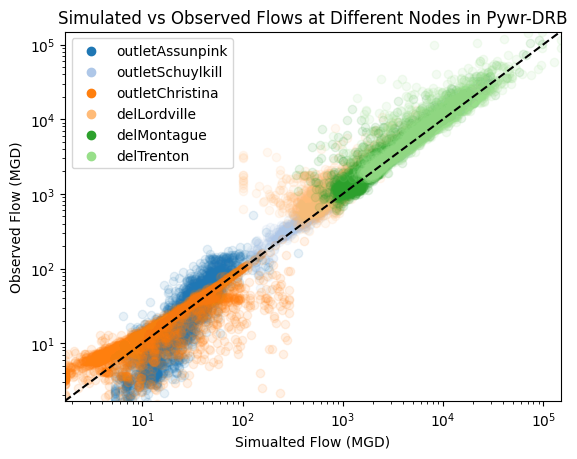

In [64]:
# Specify nodes of interest
plot_flows = ['outletAssunpink', 'outletSchuylkill', 'outletChristina', 'delLordville', 'delMontague', 'delTrenton']
start_date = '2000-01-01'

# Construct scatter plot of observed vs simulated flows
fig, ax = plt.subplots()
cmap = plt.colormaps['tab20']
min_flow = simulated_flows.min().min()
max_flow = simulated_flows.max().max()
ax.axline((min_flow, min_flow), (max_flow, max_flow), linewidth=1.5, linestyle = 'dashed', color='black')
for i,col in enumerate(plot_flows):
    ax.scatter(simulated_flows.loc[start_date:, col], observed_flows.loc[start_date:,col], alpha = 0.1, color = cmap(i), label = col)
ax.set_xlabel('Simualted Flow (MGD)')
ax.set_ylabel('Observed Flow (MGD)')
ax.set_title('Simulated vs Observed Flows at Different Nodes in Pywr-DRB')

legend = plt.legend()
for handle in legend.legend_handles:
    handle.set_alpha(1)
plt.yscale('log')
plt.xscale('log')
plt.ylim([min_flow, max_flow])
plt.xlim([min_flow, max_flow])
plt.show()